# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of four classes: Normal, Viral, Pneumonio, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

### About COVID-19 Dataset
A database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. This COVID-19 dataset contains 3616 COVID-19 positive cases along with 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection) and 1345 Viral Pneumonia images.

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from PIL import Image
from matplotlib import pyplot as plt
from torchsummary import summary
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

torch.manual_seed(0)

In [2]:
print('cuda available' if torch.cuda.is_available() else 'cuda not available')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

cuda available
device: cuda:0


# Data Preparation

In [3]:
class_names = ['normal', 'viral', 'covid', 'lung']
class_fullnames = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung Opacity']

source_dirs = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung_Opacity']
root_dir = 'COVID-19_Radiography_Dataset'

test_cases = 100
valid_cases = 100
num_classes = len(class_names)

if not os.path.isdir(os.path.join(root_dir, 'test')):
    os.mkdir(os.path.join(root_dir, 'test'))
    
    if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
        for i, d in enumerate(source_dirs):
            os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))
    
    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))
    
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, test_cases)
        
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)
            
if not os.path.isdir(os.path.join(root_dir, 'valid')):
    os.mkdir(os.path.join(root_dir, 'valid'))
    
    if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
        for i, d in enumerate(source_dirs):
            os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))
    
    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'valid', c))
    
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, valid_cases)
        
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'valid', c, image)
            shutil.move(source_path, target_path) 

In [4]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = class_names
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, idx):
        class_name = random.choice(self.class_names)
        idx = idx % len(self.images[class_name])
        image_name = self.images[class_name][idx]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        
        return self.transform(image), self.class_names.index(class_name)

In [5]:
train_transform = torchvision.transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

In [6]:
test_transform = torchvision.transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

In [7]:
train_dirs = {'normal': os.path.join(root_dir, 'normal'),
                'lung': os.path.join(root_dir, 'lung'),
               'covid': os.path.join(root_dir, 'covid'),
               'viral': os.path.join(root_dir, 'viral')}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 9992 normal examples
Found 1145 viral examples
Found 3416 covid examples
Found 5812 lung examples


In [8]:
test_dirs = {'normal': os.path.join(root_dir, 'test', 'normal'),
               'lung': os.path.join(root_dir, 'test', 'lung'),
              'covid': os.path.join(root_dir, 'test', 'covid'),
              'viral': os.path.join(root_dir, 'test', 'viral')}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 100 normal examples
Found 100 viral examples
Found 100 covid examples
Found 100 lung examples


In [9]:
valid_dirs = {'normal': os.path.join(root_dir, 'valid', 'normal'),
               'lung': os.path.join(root_dir, 'valid', 'lung'),
              'covid': os.path.join(root_dir, 'valid', 'covid'),
              'viral': os.path.join(root_dir, 'valid', 'viral')}

valid_dataset = ChestXRayDataset(valid_dirs, test_transform)

Found 100 normal examples
Found 100 viral examples
Found 100 covid examples
Found 100 lung examples


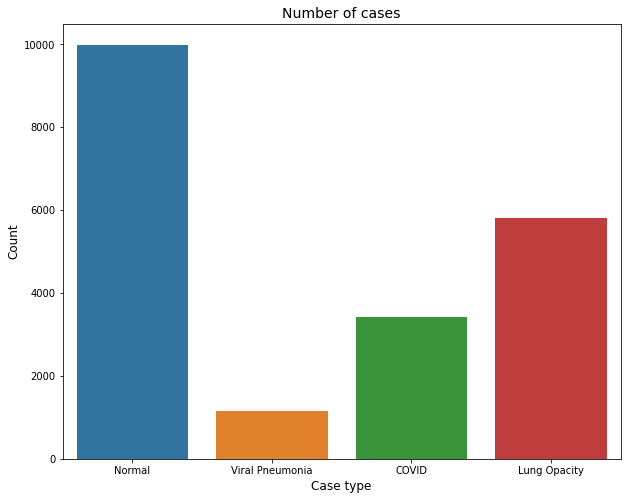

In [10]:
cases_count = []
for class_name in class_names:
    cases_count.append(len(train_dataset.images[class_name]))

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=class_fullnames, y=cases_count)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [11]:
batch_size = 6

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [12]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(14,4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i+1, xticks=[], yticks=[])
        image = image.cpu().detach().numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)

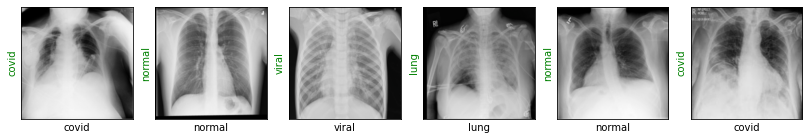

In [13]:
images, labels = next(iter(train_loader))
show_images(images, labels, labels)

# Modeling

In [14]:
resnet18 = models.resnet18(pretrained=True)

In [15]:
summary(resnet18.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

/home/fodics/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [16]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=4)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [17]:
resnet18 = resnet18.to(device)

In [18]:
summary(resnet18, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [19]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(test_loader))
    images = images.to(device)
    outputs = resnet18(images)
    outputs = outputs.cpu().detach()
    print(outputs.shape)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

torch.Size([6, 4])


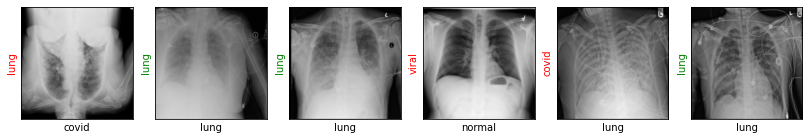

In [20]:
show_preds()

In [21]:

            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                acc = 0
                val_loss = 0
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(valid_loader):
                    images, labels = images.to(device), labels.to(device)
                    outputs = resnet18(images)
                    loss = criterion(outputs, labels)
                    val_loss = loss.item()
                    _, preds = torch.max(outputs, 1)
                    preds = preds.cpu().detach()
                    labels = labels.cpu().detach()
                    acc += sum((preds == labels).numpy())
                val_loss /= (val_step + 1)
                acc = acc / len(valid_dataset)
                print(f'Val loss: {val_loss:.6f}, Acc: {acc:.6f}')
                
                resnet18.train()
                

NameError: name 'train_step' is not defined

In [29]:
train_losses = []
train_accuracies = []

def train(epoch):
    
    print('\nEpoch : %d'%epoch)

    resnet18.train()
    running_loss = 0
    correct = 0
    total = 0      
    
    for train_step, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)
      
    train_loss = running_loss / len(trainloader)
    accuracy = 100.* correct / total
  
    train_accuracies.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))          

In [30]:
eval_losses = []
eval_accuracies = []

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0

    with torch.no_grad():
        for data in tqdm(testloader):
        images,labels=data[0].to(device),data[1].to(device)
      
        outputs=model(images)

        loss= loss_fn(outputs,labels)
        running_loss+=loss.item()
      
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
  
    test_loss=running_loss/len(testloader)
    accuracy = 100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

IndentationError: expected an indented block (4087812838.py, line 13)

In [ ]:
epochs=10
for epoch in range(1,epochs+1): 
    train(epoch)
    #test(epoch)

torch.Size([6, 4])


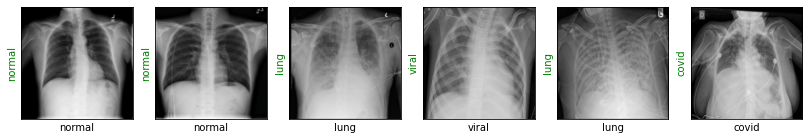

In [23]:
show_preds()

In [27]:
print(f'Total accuracy: {np.sum(labels == preds) / len(labels) * 100.}%')

Total accuracy: 94.5%


In [153]:
def eval_classifier(model, test_loader, plot_roc_curve = False):
    
    def indices_to_one_hot(data, nb_classes):
        """Convert an iterable of indices to one-hot encoded labels."""
        targets = np.array(data).reshape(-1)
        return np.eye(nb_classes)[targets]
    
    model.eval()
           
    score_list   = torch.Tensor([])
    pred_list    = torch.Tensor([]).long()
    target_list  = torch.Tensor([]).long()
    
    for iter_num, (images, labels) in enumerate(test_loader):        
        images, labels = images.to(device), labels.to(device)        
        outputs = model(images)                
        labels = labels.cpu().detach()    
        outputs = outputs.cpu().detach()        
        score_list   = torch.cat([score_list, torch.nn.Softmax(dim = 1)(outputs).squeeze()])
        target_list  = torch.cat([target_list, labels.squeeze()])
        _, preds = torch.max(outputs, 1)
        pred_list = torch.cat([pred_list, preds.squeeze()])
    
    pred_list = pred_list.numpy()
    target_list = target_list.numpy()
    score_list = score_list.numpy()
    
    cm  = confusion_matrix(target_list, pred_list) 
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
    
    plot_confusion_matrix(cm, hide_ticks=True, cmap=plt.cm.Blues, axis=axes[0])
    
    axes[0].set_xlabel('Predicted labels', fontsize=12)
    axes[0].set_ylabel('True labels', fontsize=12)
    
    axes[0].set_xticks(range(4), class_fullnames, fontsize=11)
    axes[0].set_yticks(range(4), class_fullnames, fontsize=11)
    axes[0].set_title('Confusion Matrix', fontsize=16)
    
    target_list = indices_to_one_hot(target_list, num_classes)
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(target_list[:, i], score_list[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    for i in range(num_classes):
        
        axes[1].plot(fpr[i], tpr[i], label=f'{class_fullnames[i]} (area = %0.2f)' % roc_auc[i])
        axes[1].plot([0, 1], [0, 1], 'k--')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])

        axes[1].set_xlabel('False Positive Rate', fontsize=12)
        axes[1].set_ylabel('True Positive Rate', fontsize=12)
        axes[1].set_title('ROC Curve', fontsize=16)
        axes[1].legend(loc="lower right")
        
    plt.tight_layout()  
    plt.show()

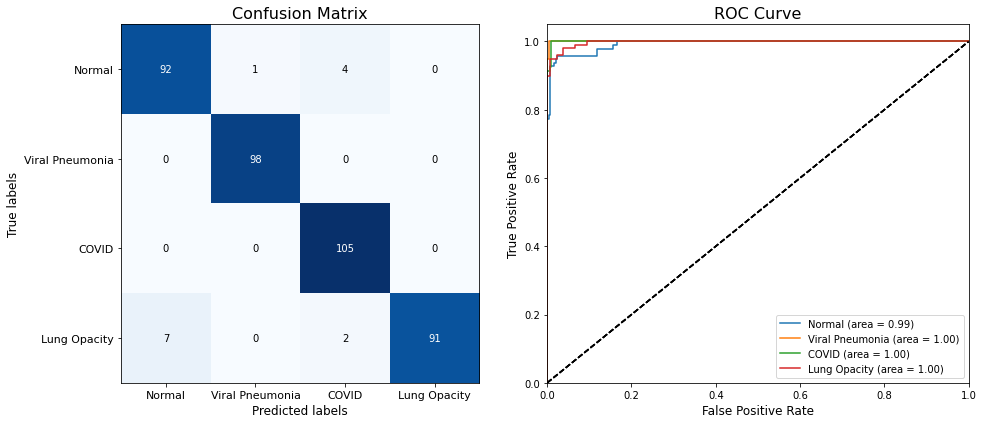

In [154]:
eval_classifier(resnet18, test_loader)